## Descripción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. El objetivo es desarrollar un sistema para filtrar y categorizar reseñas de películas, entrenando un modelo que detecte automáticamente críticas negativas. Utilizaremos un conjunto de datos de reseñas de películas de IMDB para construir un modelo que clasifique las reseñas como positivas o negativas, con una meta de alcanzar un valor F1 de al menos 0.85.

## Inicialización

Primero, importamos las librerías necesarias para el proyecto, como pandas para manipulación de datos, matplotlib y seaborn para visualización, y sklearn para modelado, entre otras.

In [31]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import re
import string

import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import spacy

from lightgbm import LGBMClassifier

import torch
import transformers

import logging

In [2]:
# Generar el archivo requirements.txt
!pip freeze > requirements.txt

Configuracion inicial.

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [4]:
tqdm.pandas()

In [5]:
random_state = np.random.RandomState(417)

## Cargar datos

Cargamos los datos de reseñas desde un archivo .tsv y verificamos la estructura y contenido del DataFrame.

In [6]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

A 'average_rating' y 'votes' les faltan dos valores. Arreglemoslo,  limpiamos los datos rellenando los valores nulos en las columnas 'average_rating' y 'votes' con la media de cada columna.

In [8]:
df_reviews['average_rating'].fillna(df_reviews['average_rating'].mean(), inplace=True)

In [9]:
df_reviews['votes'].fillna(round(df_reviews['votes'].mean()), inplace=True)

## EDA

Veamos el número de películas y reseñas a lo largo de los años. Primero crearemos dos par de funciones que nos ayudara con la visualizacion.

In [29]:
def plot_reviews_over_years(df):
    """
    Visualiza el número de películas y reseñas a lo largo de los años.

    Parámetros:
    ----------
    df : DataFrame
        DataFrame que contiene los datos de las reseñas de películas con una columna 'start_year' que indica el año de inicio.

    Devuelve:
    --------
    None
        Muestra dos gráficos de barras: uno con el número de películas por año y otro con el número de reseñas por año, diferenciando entre reseñas positivas y negativas.
    """
    fig, axs = plt.subplots(2, 1, figsize=(16, 10))

    dft1 = df[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()
    dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
    dft1.plot(kind='bar', ax=axs[0])
    axs[0].set_title('Número de películas a lo largo de los años')

    dft2 = df.groupby(['start_year', 'pos'])['pos'].count().unstack()
    dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
    dft2.plot(kind='bar', stacked=True, ax=axs[1])
    
    dft2_reviews = df['start_year'].value_counts().sort_index()
    dft2_reviews = dft2_reviews.reindex(index=np.arange(dft2_reviews.index.min(), max(dft2_reviews.index.max(), 2021))).fillna(0)
    dft3 = (dft2_reviews/dft1).fillna(0)
    axt = axs[1].twinx()
    dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

    lines, labels = axt.get_legend_handles_labels()
    axs[1].legend(lines, labels, loc='upper left')
    axs[1].set_title('Número de reseñas a lo largo de los años')

    fig.tight_layout()
    plt.show()
    
    
def plot_review_distribution(df):
    """
    Visualiza la distribución del número de reseñas por película.

    Parámetros:
    ----------
    df : DataFrame
        DataFrame que contiene los datos de las reseñas de películas.

    Devuelve:
    --------
    None
        Muestra dos gráficos: un gráfico de barras y un gráfico KDE (Kernel Density Estimate) que muestran la distribución del número de reseñas por película.
    """
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))

    dft = df.groupby('tconst')['review'].count().value_counts().sort_index()
    dft.plot.bar(ax=axs[0])
    axs[0].set_title('Gráfico de barras de # Reseñas por película')

    dft = df.groupby('tconst')['review'].count()
    sns.kdeplot(dft, ax=axs[1])
    axs[1].set_title('Gráfico KDE de # Reseñas por película')

    fig.tight_layout()
    plt.show()
    

def plot_polarity_distribution(df, part):
    """
    Visualiza la distribución de polaridades en las reseñas de películas para una parte específica del conjunto de datos.

    Parámetros:
    ----------
    df : DataFrame
        DataFrame que contiene los datos de las reseñas de películas.
        
    part : str
        Parte del conjunto de datos a visualizar ('train' o 'test').

    Devuelve:
    --------
    None
        Muestra un gráfico: un gráfico de barras que muestra la distribución de puntuaciones
    """
    fig, ax = plt.subplots(figsize=(4, 3))

    dft = df.query(f'ds_part == "{part}"')['rating'].value_counts().sort_index()
    dft = dft.reindex(index=np.arange(1, 11)).fillna(0)
    dft.plot.bar(ax=ax)
    ax.set_ylim([0, 5000])
    ax.set_title(f'El conjunto de {part}: distribución de puntuaciones')
    ax.set_xlabel('Puntuación')
    ax.set_ylabel('Número de reseñas')

    fig.tight_layout()
    plt.show()
    
def plot_detailed_polarity_distribution(df):
    """
    Visualiza la distribución detallada de polaridades en las reseñas de películas para los conjuntos de entrenamiento y prueba.

    Parámetros:
    ----------
    df : DataFrame
        DataFrame que contiene los datos de las reseñas de películas.

    Devuelve:
    --------
    None
        Muestra cuatro gráficos: dos gráficos de barras apiladas que muestran el número de reseñas de diferentes polaridades por año y dos gráficos KDE que muestran la distribución de polaridades por película para los conjuntos de entrenamiento y prueba.
    """
    fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

    ax = axs[0][0]
    dft = df.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
    dft.index = dft.index.astype('int')
    dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
    dft.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

    ax = axs[0][1]
    dft = df.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
    sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
    sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
    ax.legend()
    ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

    ax = axs[1][0]
    dft = df.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
    dft.index = dft.index.astype('int')
    dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
    dft.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

    ax = axs[1][1]
    dft = df.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
    sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
    sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
    ax.legend()
    ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

    fig.tight_layout()
    plt.show()

Visualizamos el número de películas y reseñas a lo largo de los años y la distribución de las reseñas por película.

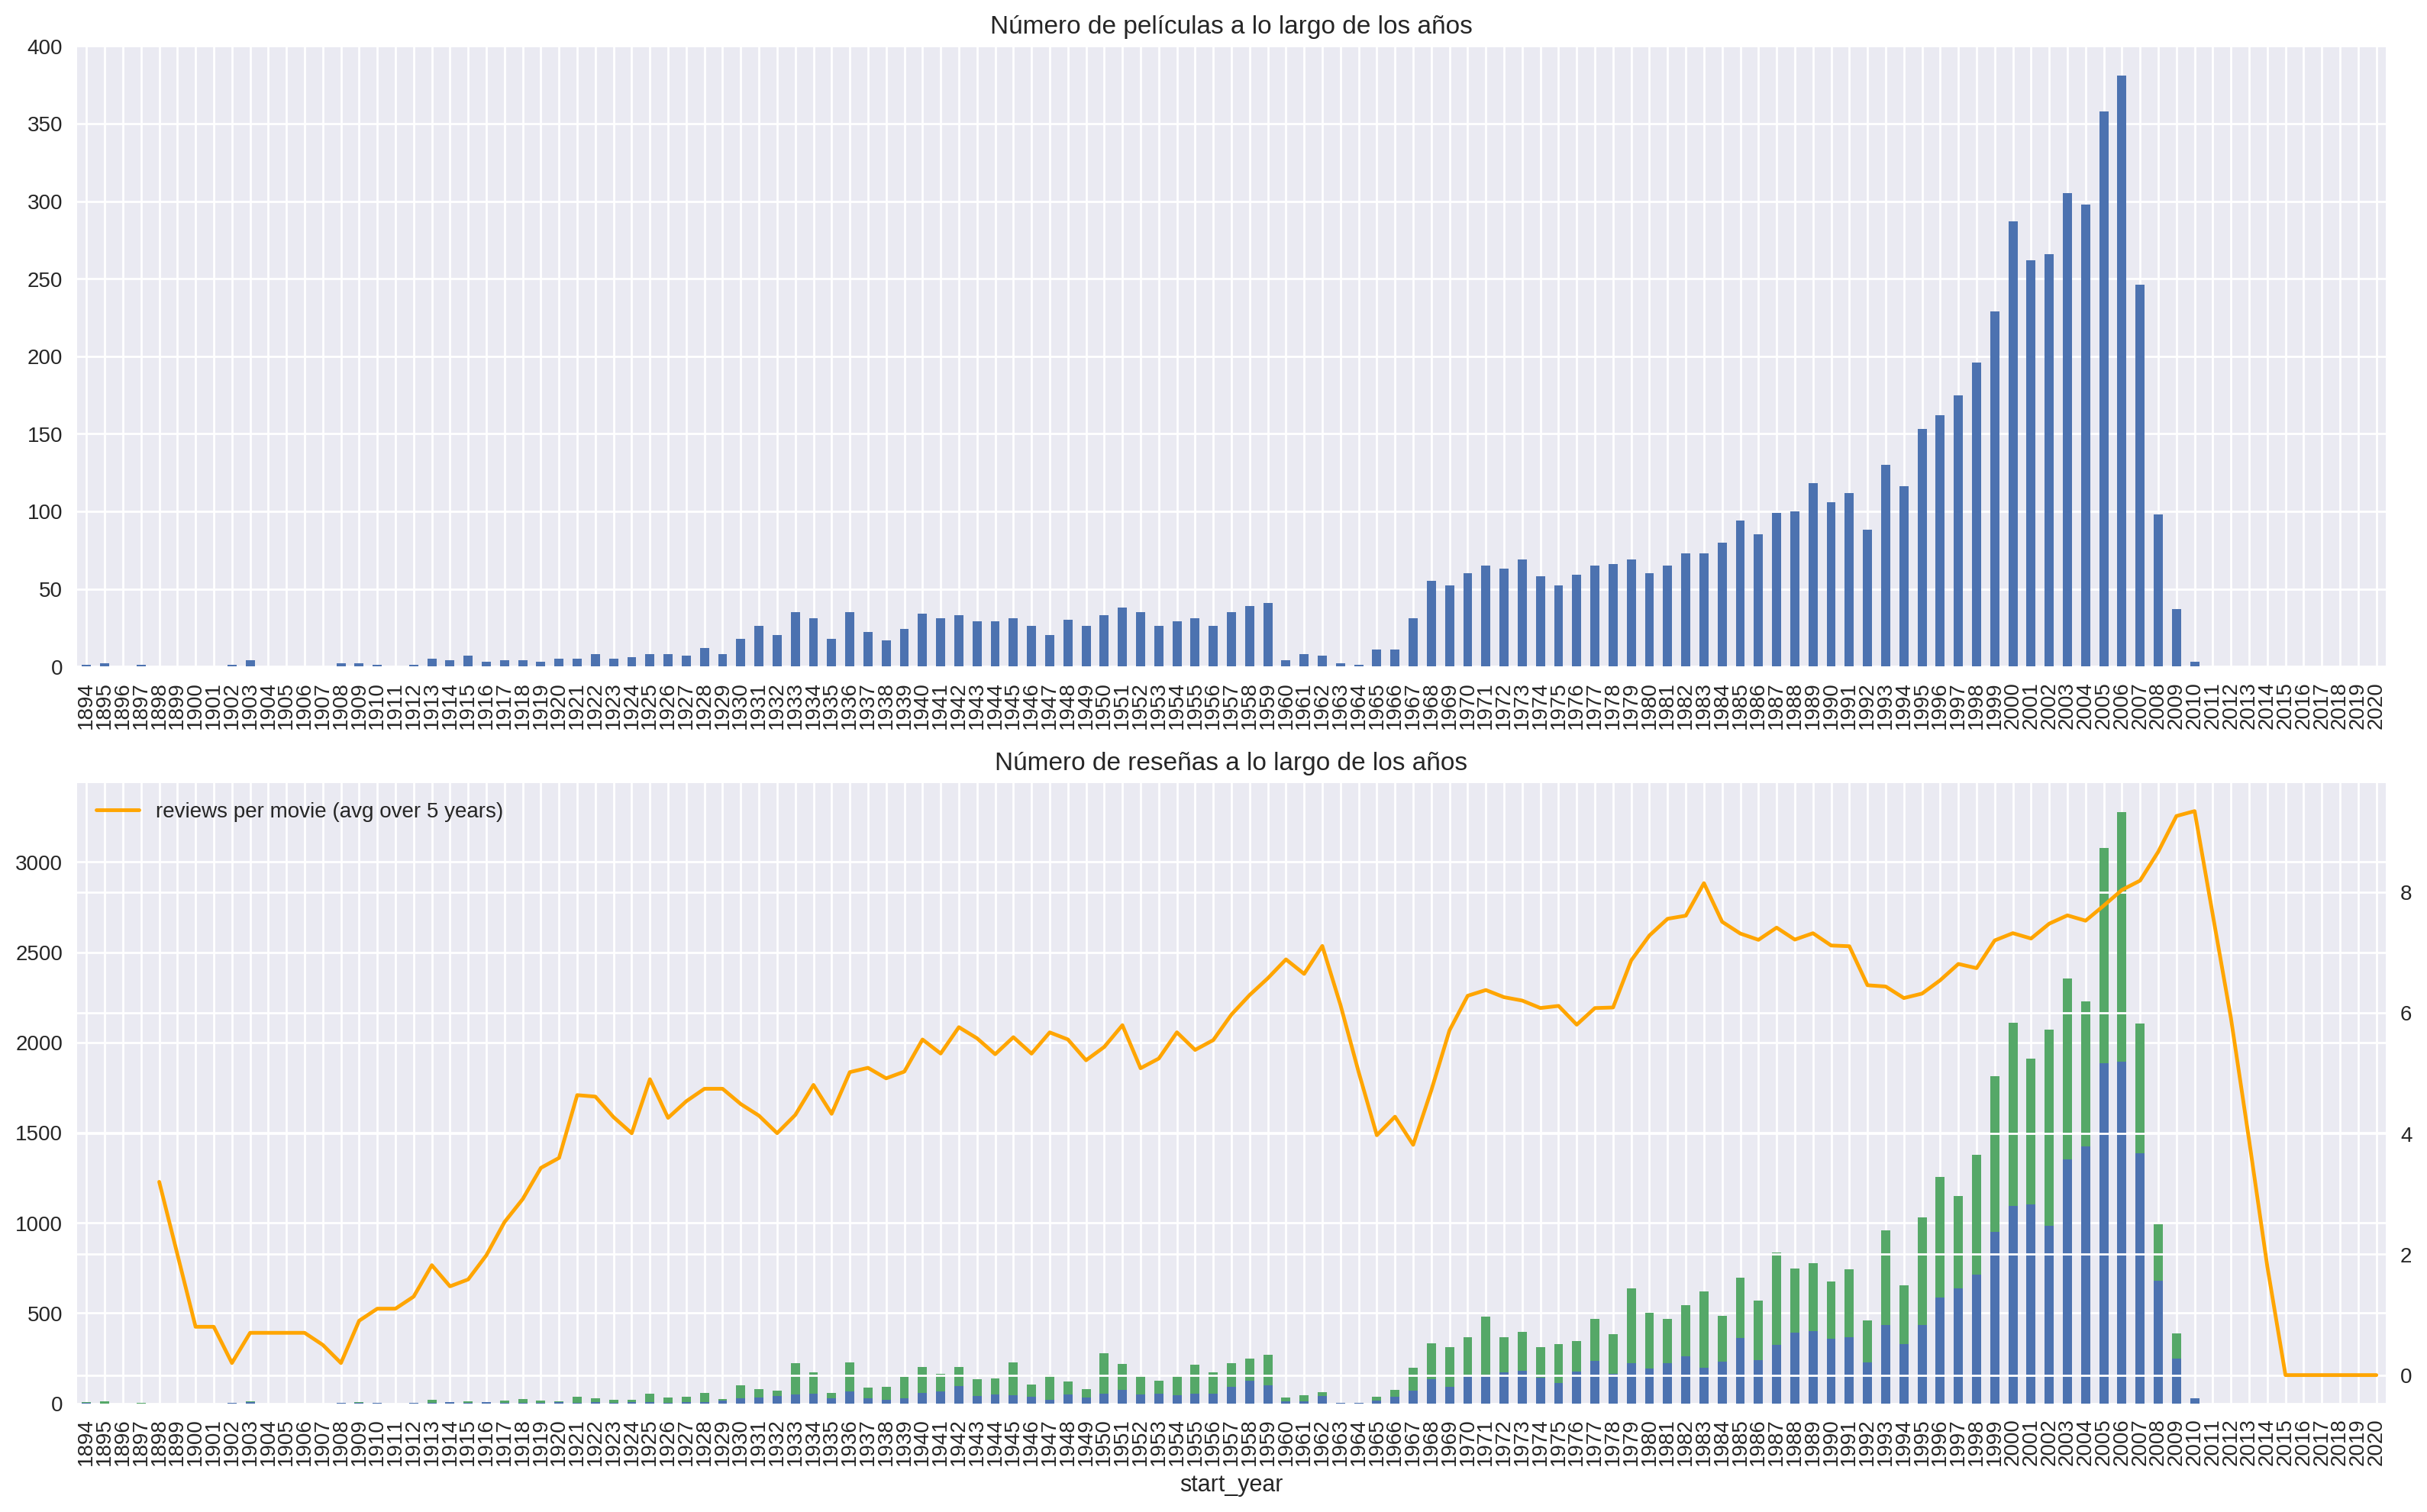

In [30]:
plot_reviews_over_years(df_reviews)

Vemos como a lo largo del tiempo el numero de reseñas por pelicula ha aumentado significativamente, aunque no ha habido un gran cambio despues de los años '10. Tambien observamos como el numero de reseñas va a la par con el numero de peliculas producidas. 

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE, solo para saber cómo puede diferir del conteo exacto.

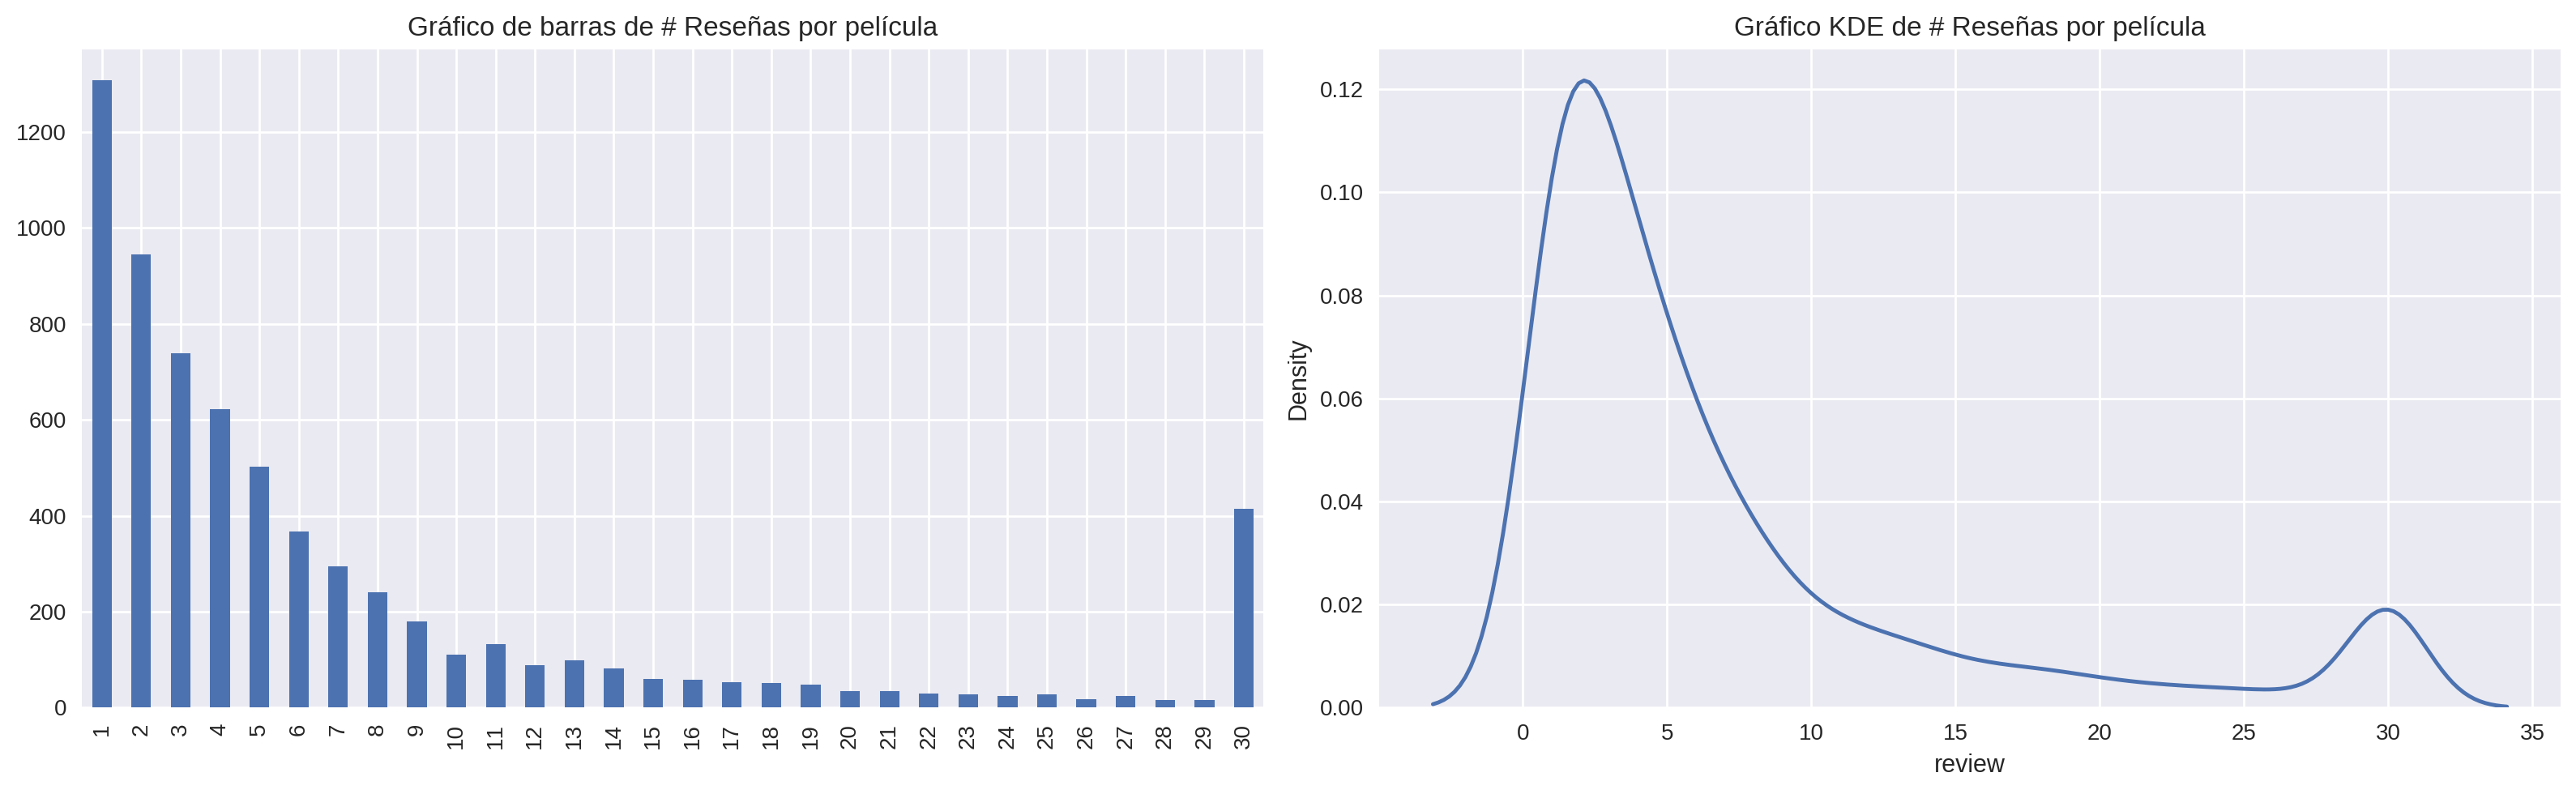

In [11]:
plot_review_distribution(df_reviews)

El suavizado muestra el conteo exacto muestran que existe una fuerte tendencia en el numero de reseñas por pelicula.

Visualizamos la distribucion de clases en los conjuntos de entrenamiento y prueba.

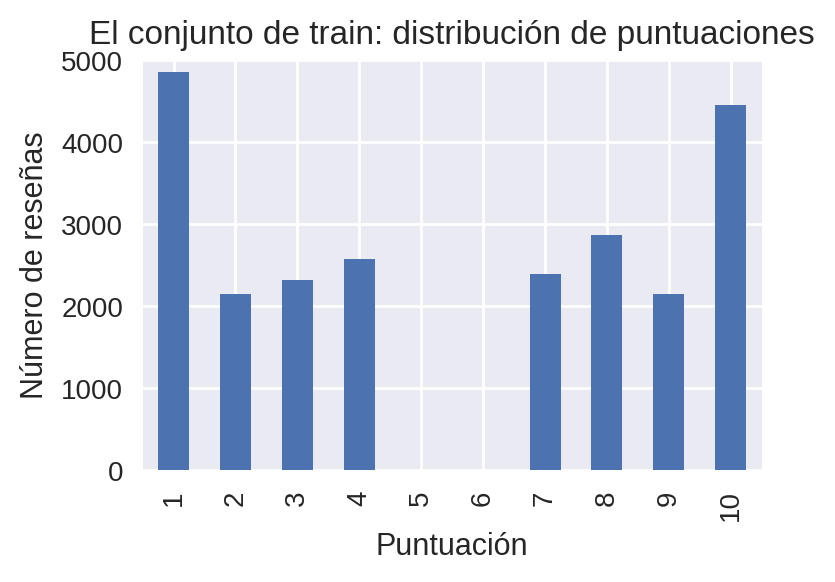

In [23]:
plot_polarity_distribution(df_reviews, 'train')

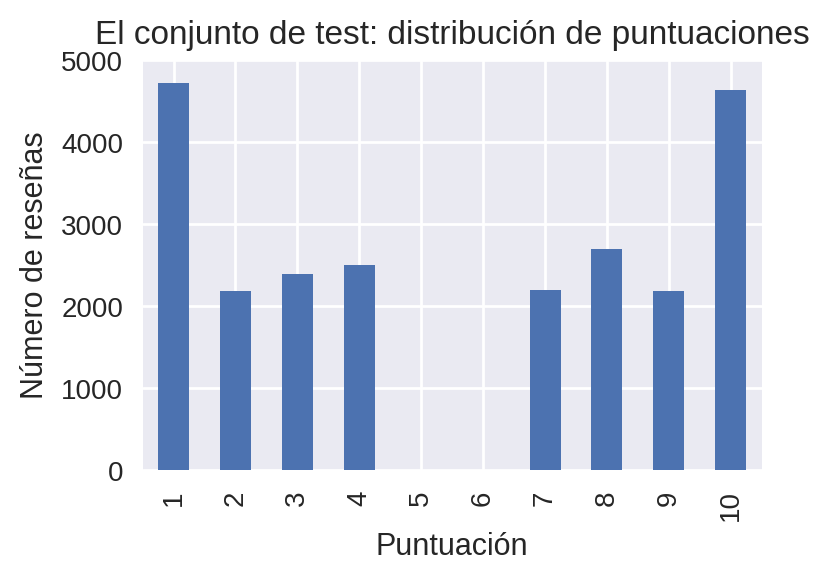

In [24]:
plot_polarity_distribution(df_reviews, 'test')

Esto nos indica que los usuarios tienden a dejar mas reseñas en los extremos que en las demas puntuaciones. Tambien nos muestra el balance entre puntuaciones, en donde el numero de reseñas con 9 puntos es muy parecido al numero de reseñas con 2 puntos y asi.

Ahora observemos como es que cambia la polaridad de las reseñas en el tiempo para los conjuntos de entrenamiento y prueba.

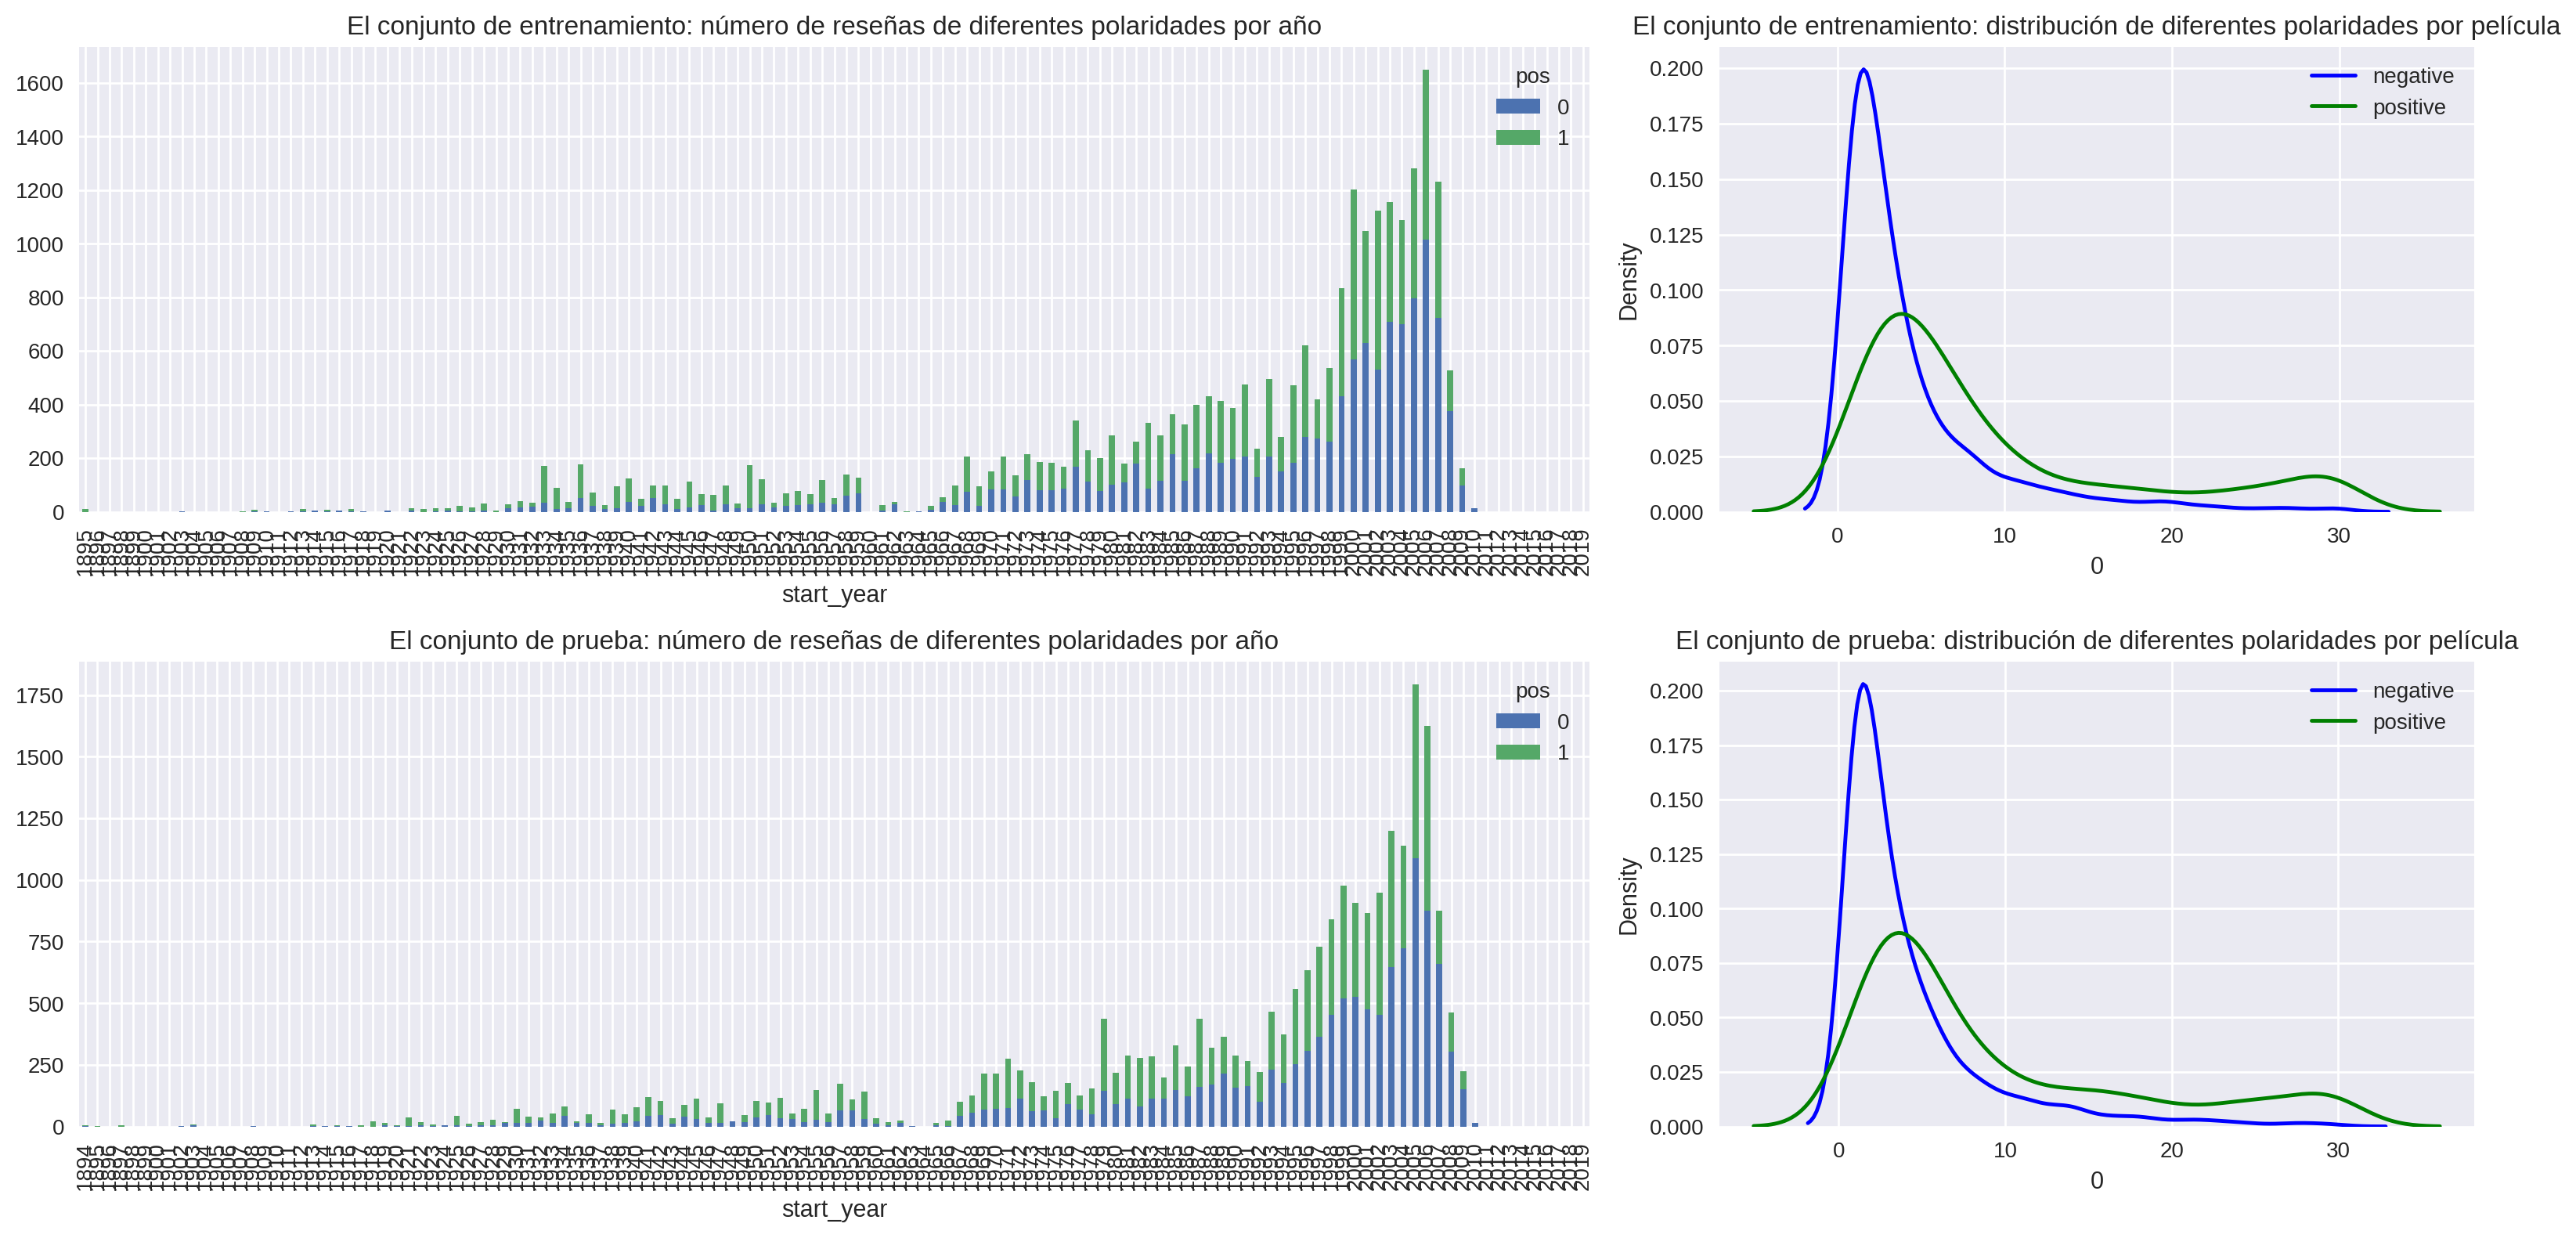

In [14]:
plot_detailed_polarity_distribution(df_reviews)

Las polaridades parecen ser similares para ambos conjuntos a lo largo del tiempo, manteniendo densidades parecidas. El numero de reseñas positivas por pelicula se distribuye mejor que el de negativas, lo que nos indica que la concentracion de reseñas negativas esta en las peliculas con menos de estas, mientras que las peliculas con mas reseñas tienden a tener mejores resultados positivos.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos.

In [15]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

Numericamente observamos la poca descompensacion de clases en nuestro conjunto. Esto es perfecto para un entrenamiento optimo, asi los modelos podran generalizar de igual forma los casos positivos como negativos.

## Procedimiento de evaluación

Diseñamos una rutina de evaluación que calcula varias métricas de rendimiento como F1, ROC AUC y APS para los modelos, permitiendo comparaciones consistentes entre ellos.

In [32]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    """
    Evalúa un modelo de clasificación utilizando múltiples métricas de rendimiento y visualiza los resultados.

    Parámetros:
    ----------
    model : object
        Modelo de clasificación entrenado que implementa los métodos predict y predict_proba.
        
    train_features : array-like or sparse matrix, shape (n_samples, n_features)
        Conjunto de características de entrenamiento.
        
    train_target : array-like, shape (n_samples,)
        Etiquetas verdaderas para el conjunto de entrenamiento.
        
    test_features : array-like or sparse matrix, shape (n_samples, n_features)
        Conjunto de características de prueba.
        
    test_target : array-like, shape (n_samples,)
        Etiquetas verdaderas para el conjunto de prueba.

    Devuelve:
    --------
    None
        Imprime las métricas de evaluación y muestra gráficos de las curvas F1, ROC y PRC para los conjuntos de entrenamiento y prueba.

    Descripción:
    -----------
    Esta función evalúa un modelo de clasificación utilizando varias métricas de rendimiento: exactitud, F1, AUC-ROC y APS (Average Precision Score).
    Genera gráficos para visualizar el rendimiento del modelo en términos de:
    - Curvas F1 para diferentes umbrales de decisión
    - Curvas ROC (Receiver Operating Characteristic)
    - Curvas PRC (Precision-Recall)
    """    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [33]:
# normalizacion de textos
def normalize_text(text):
    """
    Normaliza el texto convirtiéndolo a minúsculas y eliminando dígitos y signos de puntuación.

    Parámetros:
    ----------
    text : str
        Cadena de texto que se desea normalizar.

    Devuelve:
    --------
    str
        Texto normalizado en minúsculas y sin dígitos ni signos de puntuación.

    Descripción:
    -----------
    Esta función toma una cadena de texto y la normaliza mediante los siguientes pasos:
    1. Convierte el texto a minúsculas para evitar diferencias entre mayúsculas y minúsculas.
    2. Elimina todos los signos de puntuación utilizando una expresión regular.
    3. Elimina todos los dígitos utilizando una expresión regular.
    """
    text = text.lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'\d+', '', text)
    return text

df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

## División entrenamiento / prueba

Separamos los datos en conjuntos de entrenamiento y prueba según el indicador 'ds_part'. Asignamos las características (textos normalizados) y las etiquetas (polaridad) para ambos conjuntos.

In [34]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

train_features = df_reviews_train['review_norm']
test_features = df_reviews_test['review_norm']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 0 - Constante

Entrenamos un clasificador básico que siempre predice la clase más frecuente (mayoría).

           train  test
Exactitud    NaN   NaN
F1          0.67  0.67
APS         0.50  0.50
ROC AUC     0.50  0.50


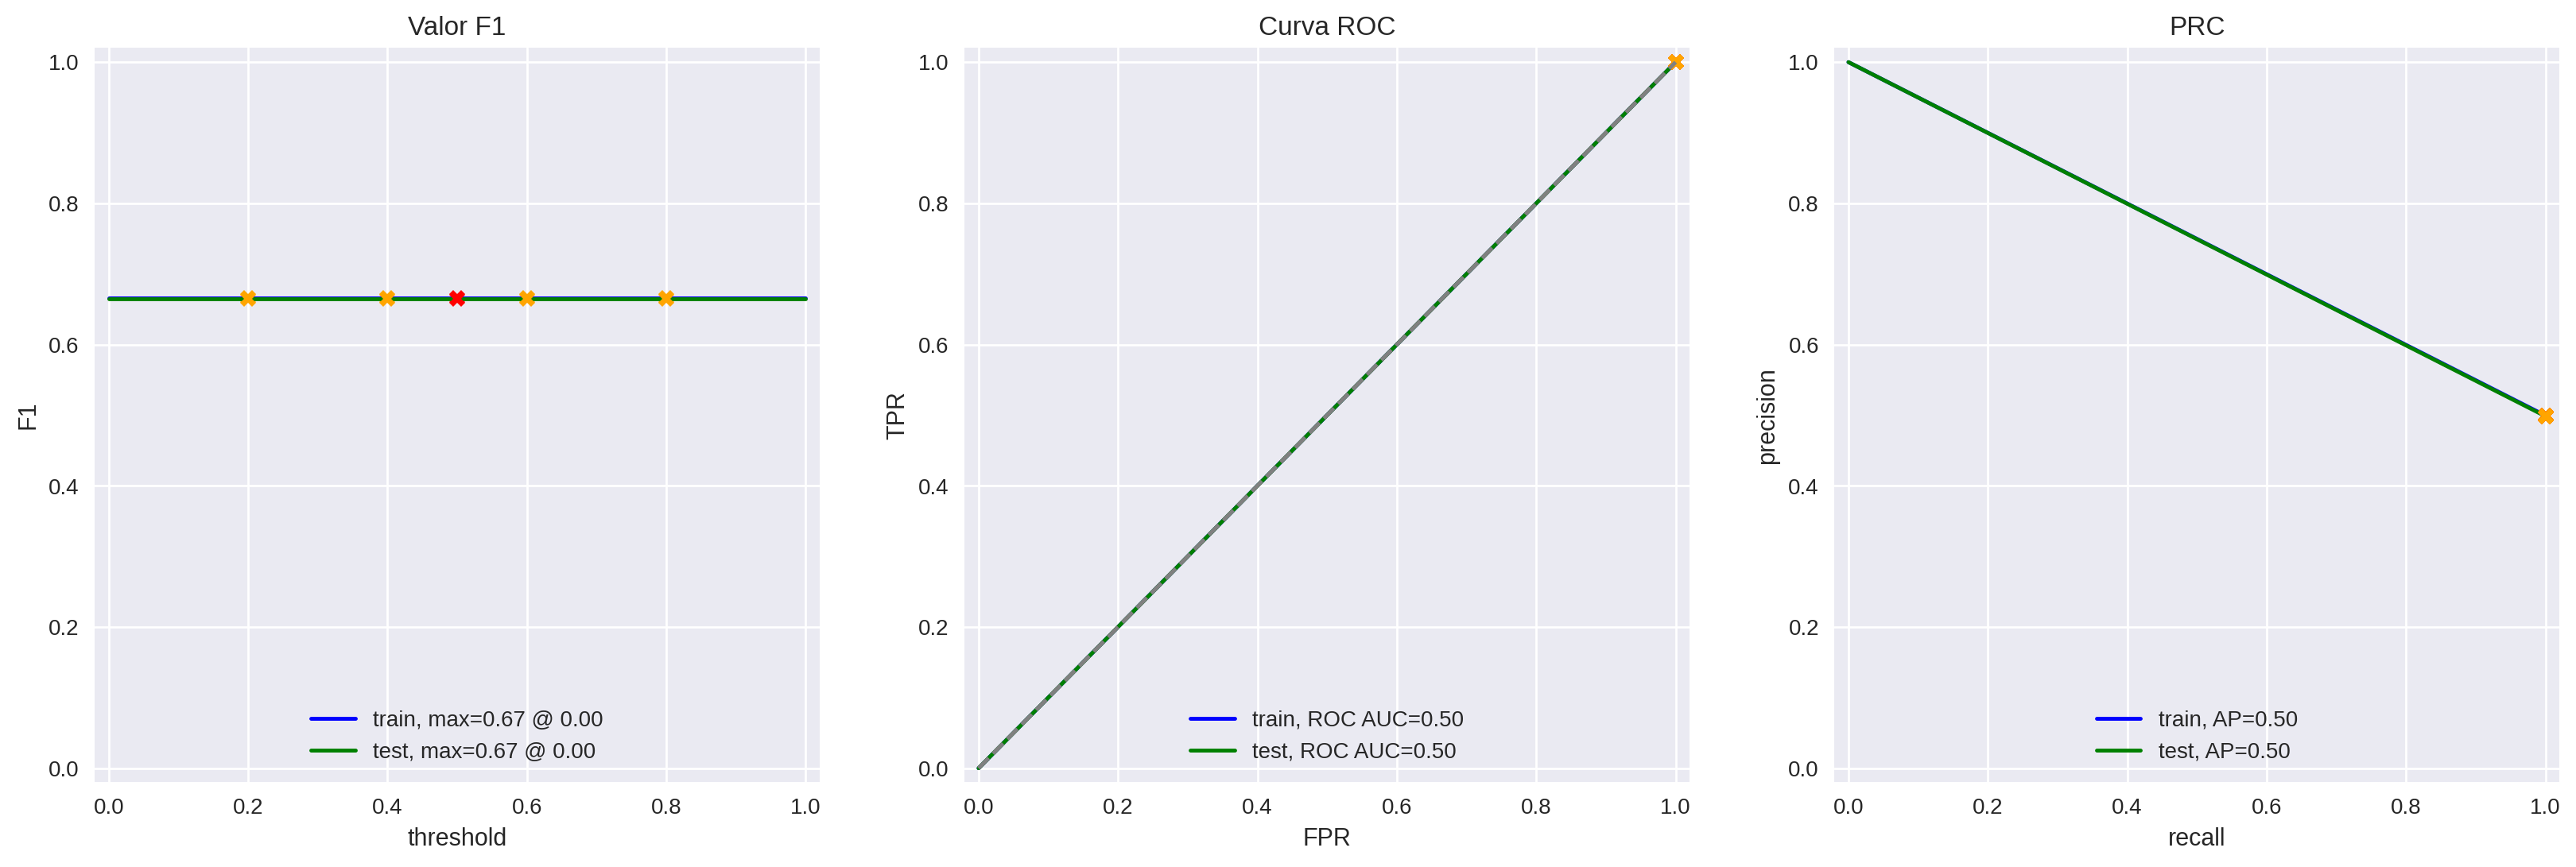

In [39]:
# modelo aleatorio
model_0 = DummyClassifier(strategy='constant', constant=1, random_state=random_state)
model_0.fit(train_features, train_target)

evaluate_model(model_0, train_features, train_target, test_features, test_target)

### Modelo 1 - NLTK, TF-IDF y LR

Utilizamos la biblioteca NLTK para remover las stopwords, y aplicamos la vectorización TF-IDF a los textos normalizados. Entrenamos un modelo de regresión logística con estas características.

In [35]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def lemmatize_and_remove_stopwords(text):
    words = nltk.word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stop_words]
    return ' '.join(lemmatized_words)

train_features_lemmatized = [lemmatize_and_remove_stopwords(text) for text in train_features]
test_features_lemmatized = [lemmatize_and_remove_stopwords(text) for text in test_features]

In [36]:
count_tf_idf_1 = TfidfVectorizer()
train_features_1 = count_tf_idf_1.fit_transform(train_features_lemmatized)
test_features_1 = count_tf_idf_1.transform(test_features_lemmatized)

In [37]:
# modelo de regresion logistica
model_1 = LogisticRegression(max_iter=500, n_jobs=-1, random_state=random_state)
model_1.fit(train_features_1, train_target)

LogisticRegression(max_iter=500, n_jobs=-1,
                   random_state=RandomState(MT19937) at 0x7EFCFFA35440)

           train  test
Exactitud    NaN   NaN
F1          0.94  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


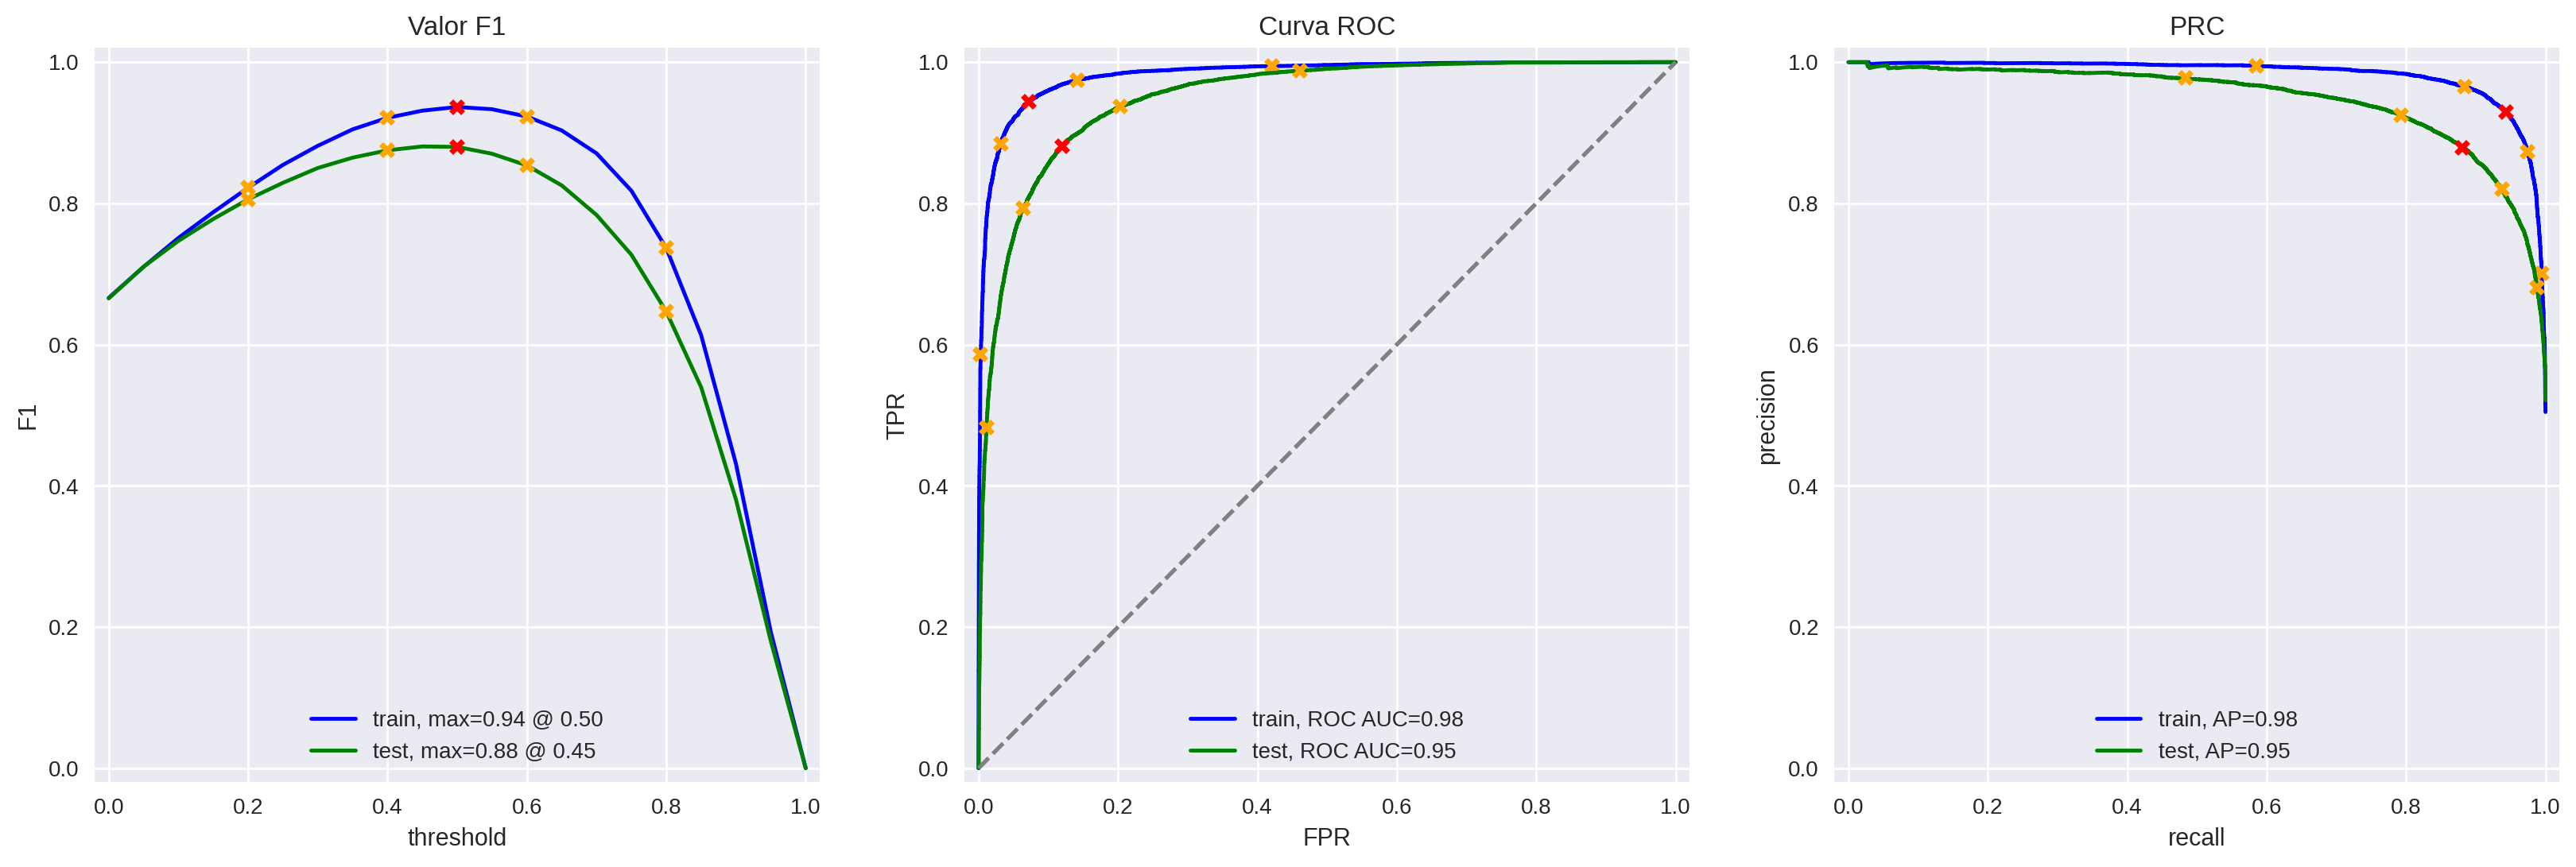

In [38]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

Este modelo mostró un rendimiento fuerte, superando el umbral F1 de 0.85.

### Modelo 2- spaCy, TF-IDF y LR

Usamos spaCy para lematizar los textos antes de aplicar TF-IDF y entrenar otro modelo de regresión logística.

In [21]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [22]:
def text_preprocessing_3(text):
    """
    Preprocesa el texto utilizando spaCy para realizar la lematización.

    Parámetros:
    ----------
    text : str
        Cadena de texto que se desea preprocesar.

    Devuelve:
    --------
    str
        Texto preprocesado donde cada palabra ha sido lematizada.

    Descripción:
    -----------
    Esta función toma una cadena de texto y la preprocesa utilizando la biblioteca spaCy. El proceso incluye:
    1. Procesar el texto con el modelo spaCy para obtener un objeto `Doc`.
    2. Extraer las lemas (formas básicas de las palabras) de cada token en el texto.
    3. Unir las lemas en una sola cadena de texto separada por espacios.
    """
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [23]:
df_reviews_train['review_norm_lemma'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_norm_lemma'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stop_words)
train_features_2 = tfidf_vectorizer_2.fit_transform(df_reviews_train['review_norm_lemma'])
test_features_2 = tfidf_vectorizer_2.transform(df_reviews_test['review_norm_lemma'])

In [37]:
print(train_features_2.shape)
print(train_target.shape)

(23796, 91187)
(23796,)


In [24]:
model_2 = LogisticRegression(max_iter=500, n_jobs=-1, random_state=random_state)
model_2.fit(train_features_2, train_target)

LogisticRegression(max_iter=500, n_jobs=-1,
                   random_state=RandomState(MT19937) at 0x7F13F6D14240)

           train  test
Exactitud    NaN   NaN
F1          0.93  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


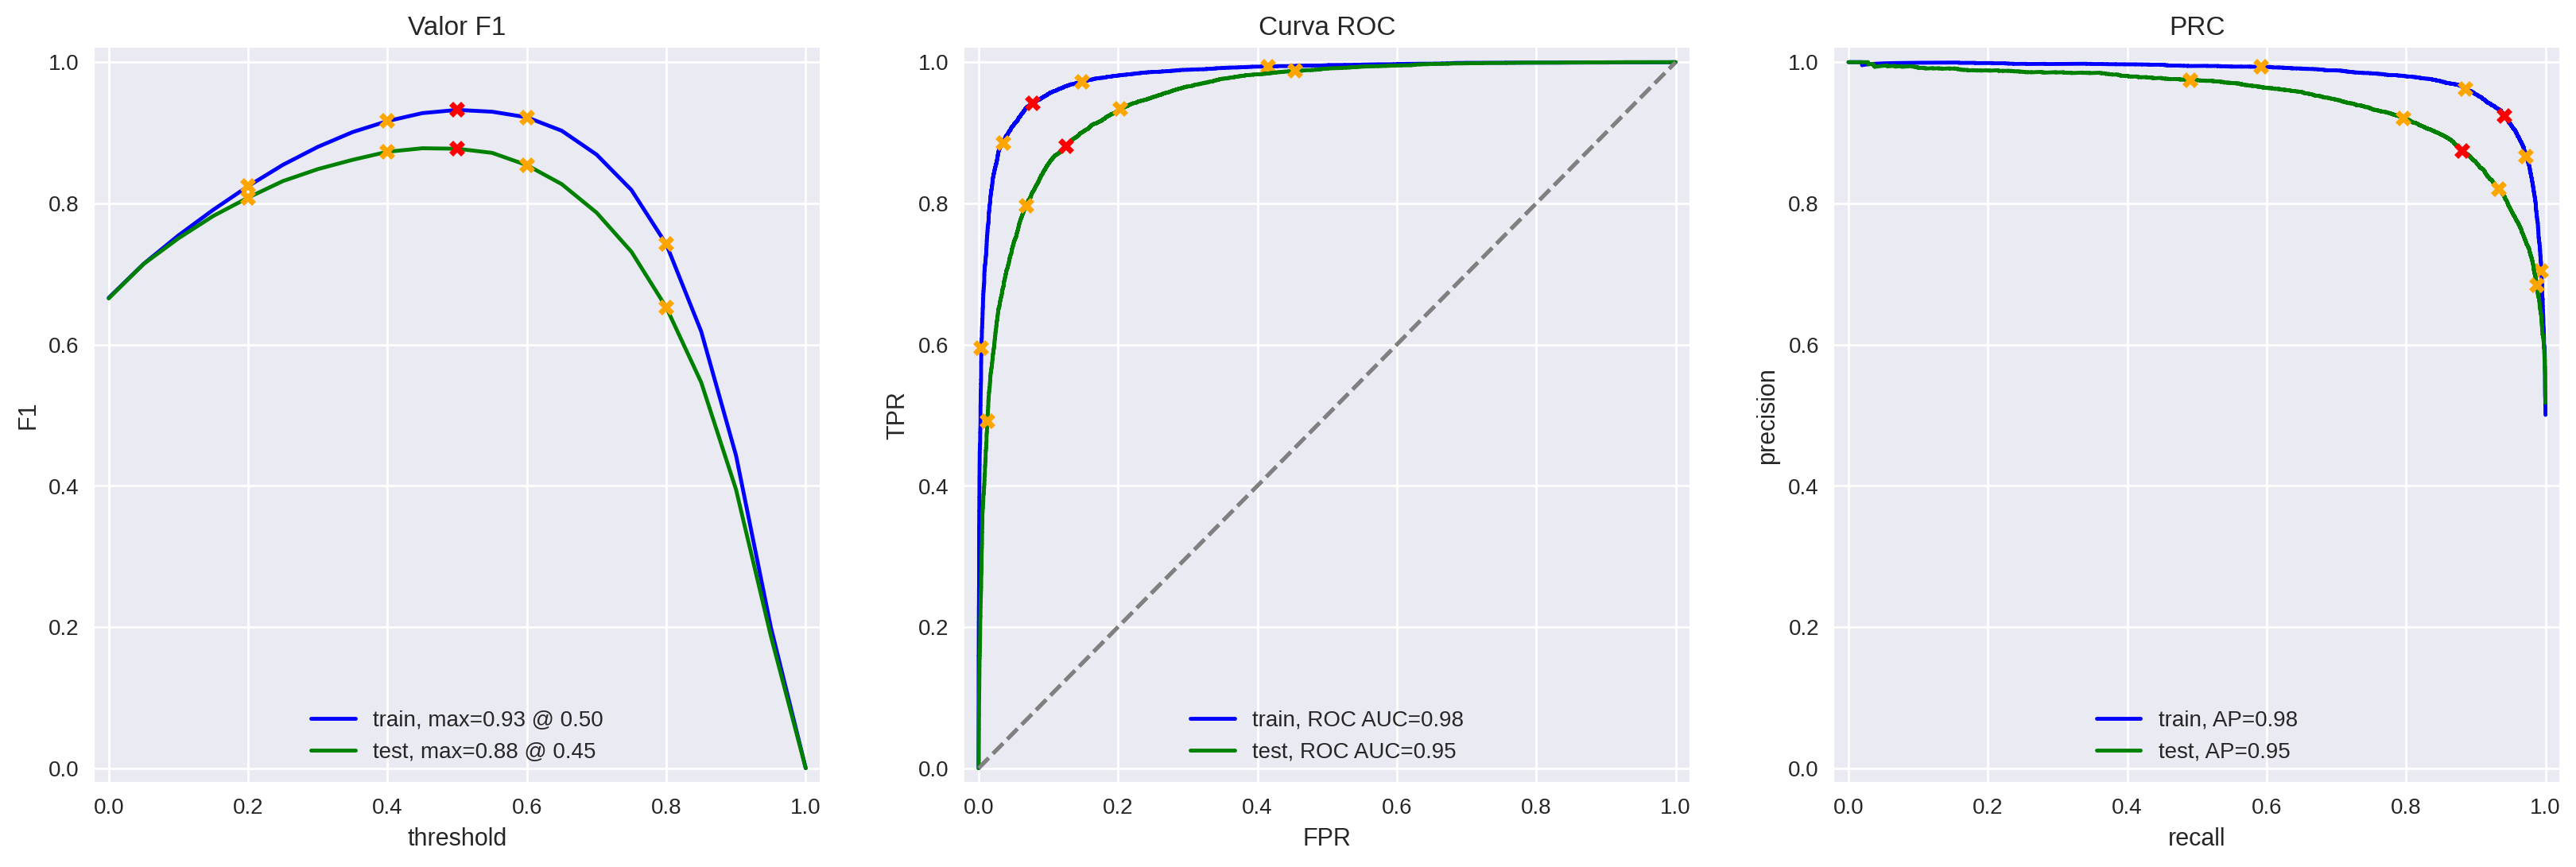

In [39]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

Similar al Modelo 1, este modelo también superó el umbral de rendimiento, pero la diferencia en rendimiento es mínima.

### Modelo 3 - spaCy, TF-IDF y LGBMClassifier

Utilizamos las características lematizadas de spaCy y TF-IDF para entrenar un modelo de clasificación con LightGBM.

In [27]:
model_3 = LGBMClassifier(random_state=random_state, n_jobs=-1)
model_3.fit(train_features_2, train_target)

LGBMClassifier(random_state=RandomState(MT19937) at 0x7F13F6D14240)

           train  test
Exactitud    NaN   NaN
F1          0.91  0.86
APS         0.97  0.93
ROC AUC     0.97  0.94


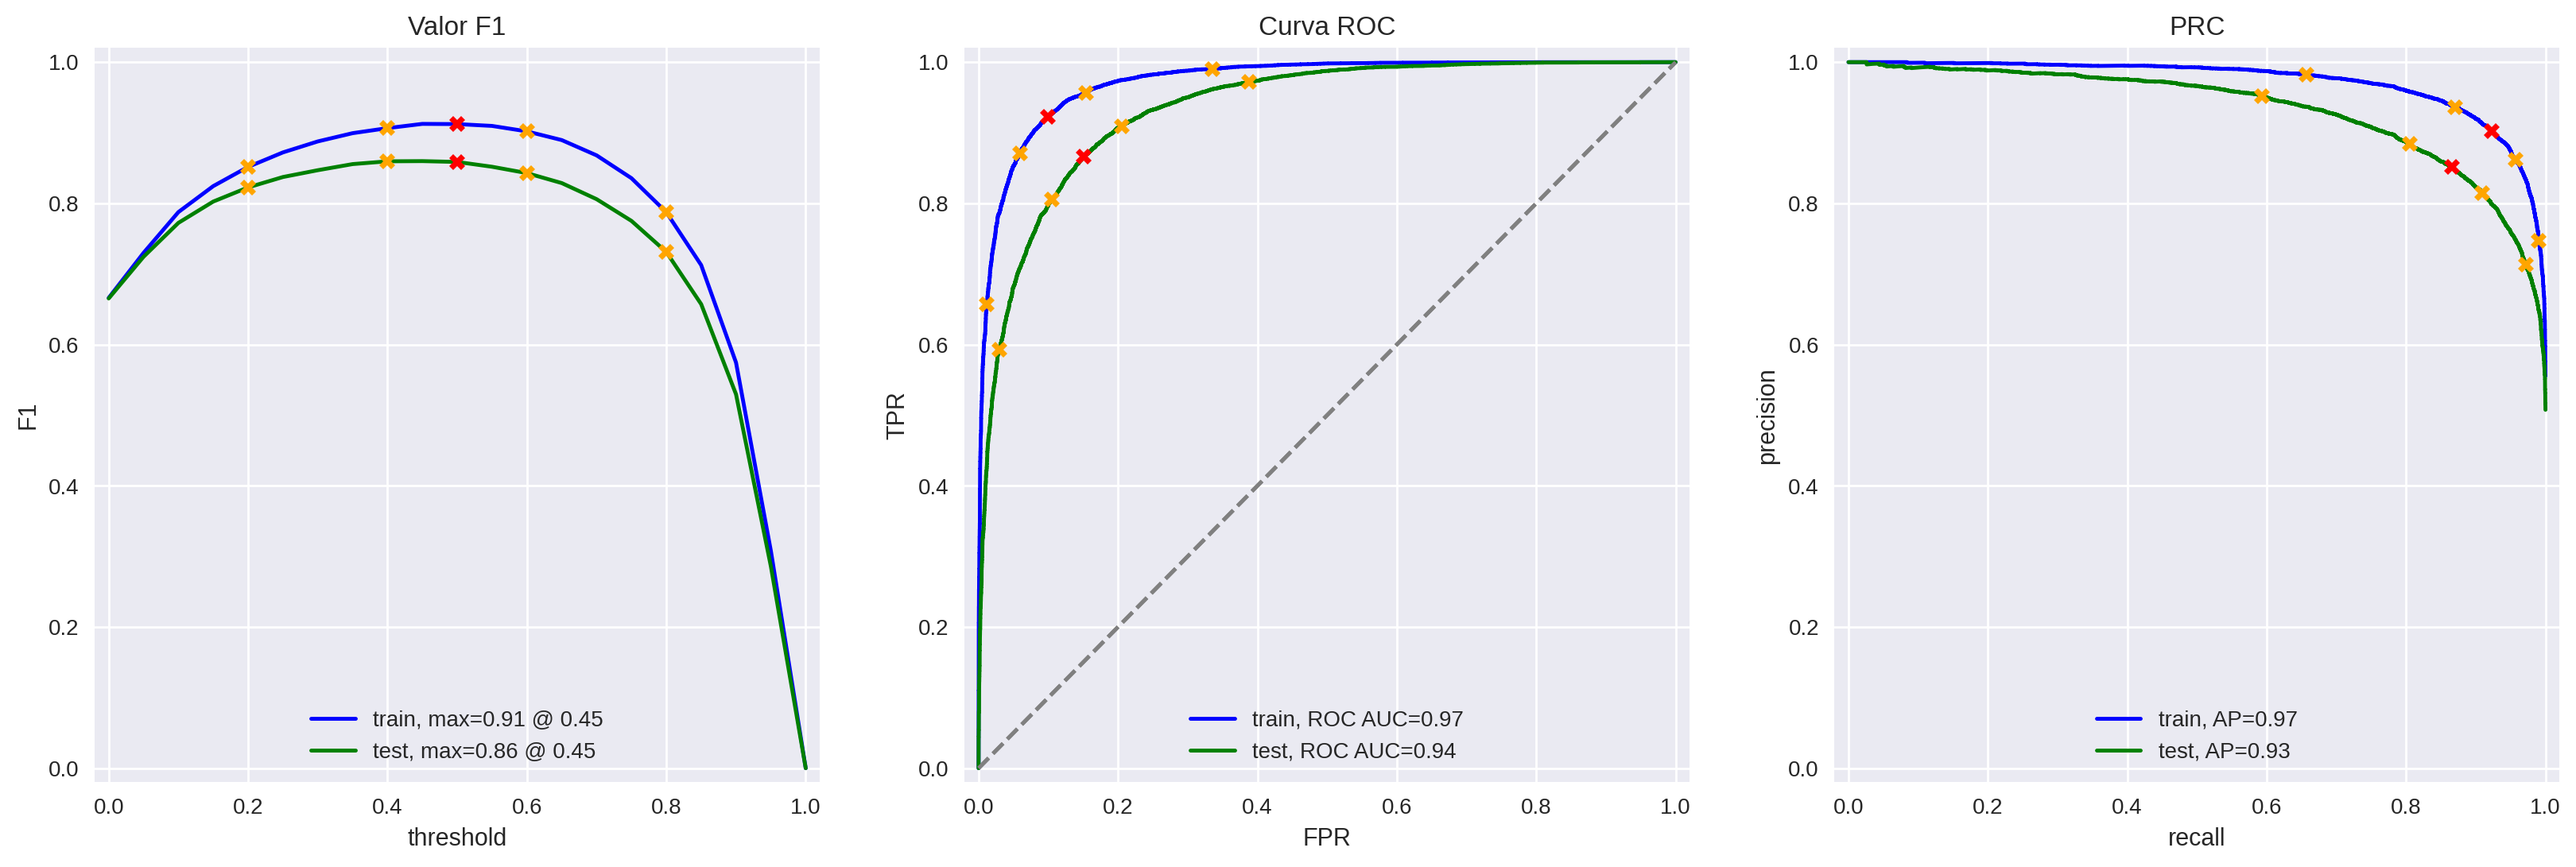

In [41]:
evaluate_model(model_3, train_features_2, train_target, test_features_2, test_target)

Aunque su rendimiento fue ligeramente inferior al de los modelos de regresión logística, aún superó el umbral F1.

###  Modelo 4 - BERT

In [12]:
# suprimir advertencia
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [13]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device='cuda', disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []
    
    for input_text in texts:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    #if force_device is not None:
    #    device = torch.device(force_device)
    #else:
    #    device = torch.device('cpu')
    device =  torch.device('cpu')
        
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')

    embeddings = []
    ids_array = np.array(ids_list)
    attention_mask_array = np.array(attention_mask_list)

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar): 
        ids_batch = torch.LongTensor(ids_array[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_array[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

Crearemos un par de cientos de embeddings y solo lo probaremos con un par de cientos del conjunto de prueba y entrenamiento.

In [14]:
train_features_bert = train_features.iloc[:100]
test_features_bert = test_features.iloc[:100]

train_features_4 = BERT_text_to_embeddings(train_features_bert, force_device='cpu', max_length=128, batch_size=10)
test_features_4 = BERT_text_to_embeddings(test_features_bert, force_device='cpu', max_length=128, batch_size=10)

# guardar los embeddings
np.savez_compressed('features_4.npz', train_features_4=train_features_4, test_features_4=test_features_4)

Uso del dispositivo cpu.


  0%|          | 0/10 [00:00<?, ?it/s]

Uso del dispositivo cpu.


  0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
print(df_reviews_train['review_norm'].shape)
print(train_features_4.shape)
print(test_features_4.shape)
print(train_target.shape)

(23796,)
(100, 768)
(100, 768)
(23796,)


In [20]:
model_4 = LogisticRegression(max_iter=500, n_jobs=-1, random_state=random_state)
model_4.fit(train_features_4, train_target.iloc[:100])

LogisticRegression(max_iter=500, n_jobs=-1,
                   random_state=RandomState(MT19937) at 0x7F4175822340)

           train  test
Exactitud    NaN   NaN
F1           1.0  0.70
APS          1.0  0.78
ROC AUC      1.0  0.76


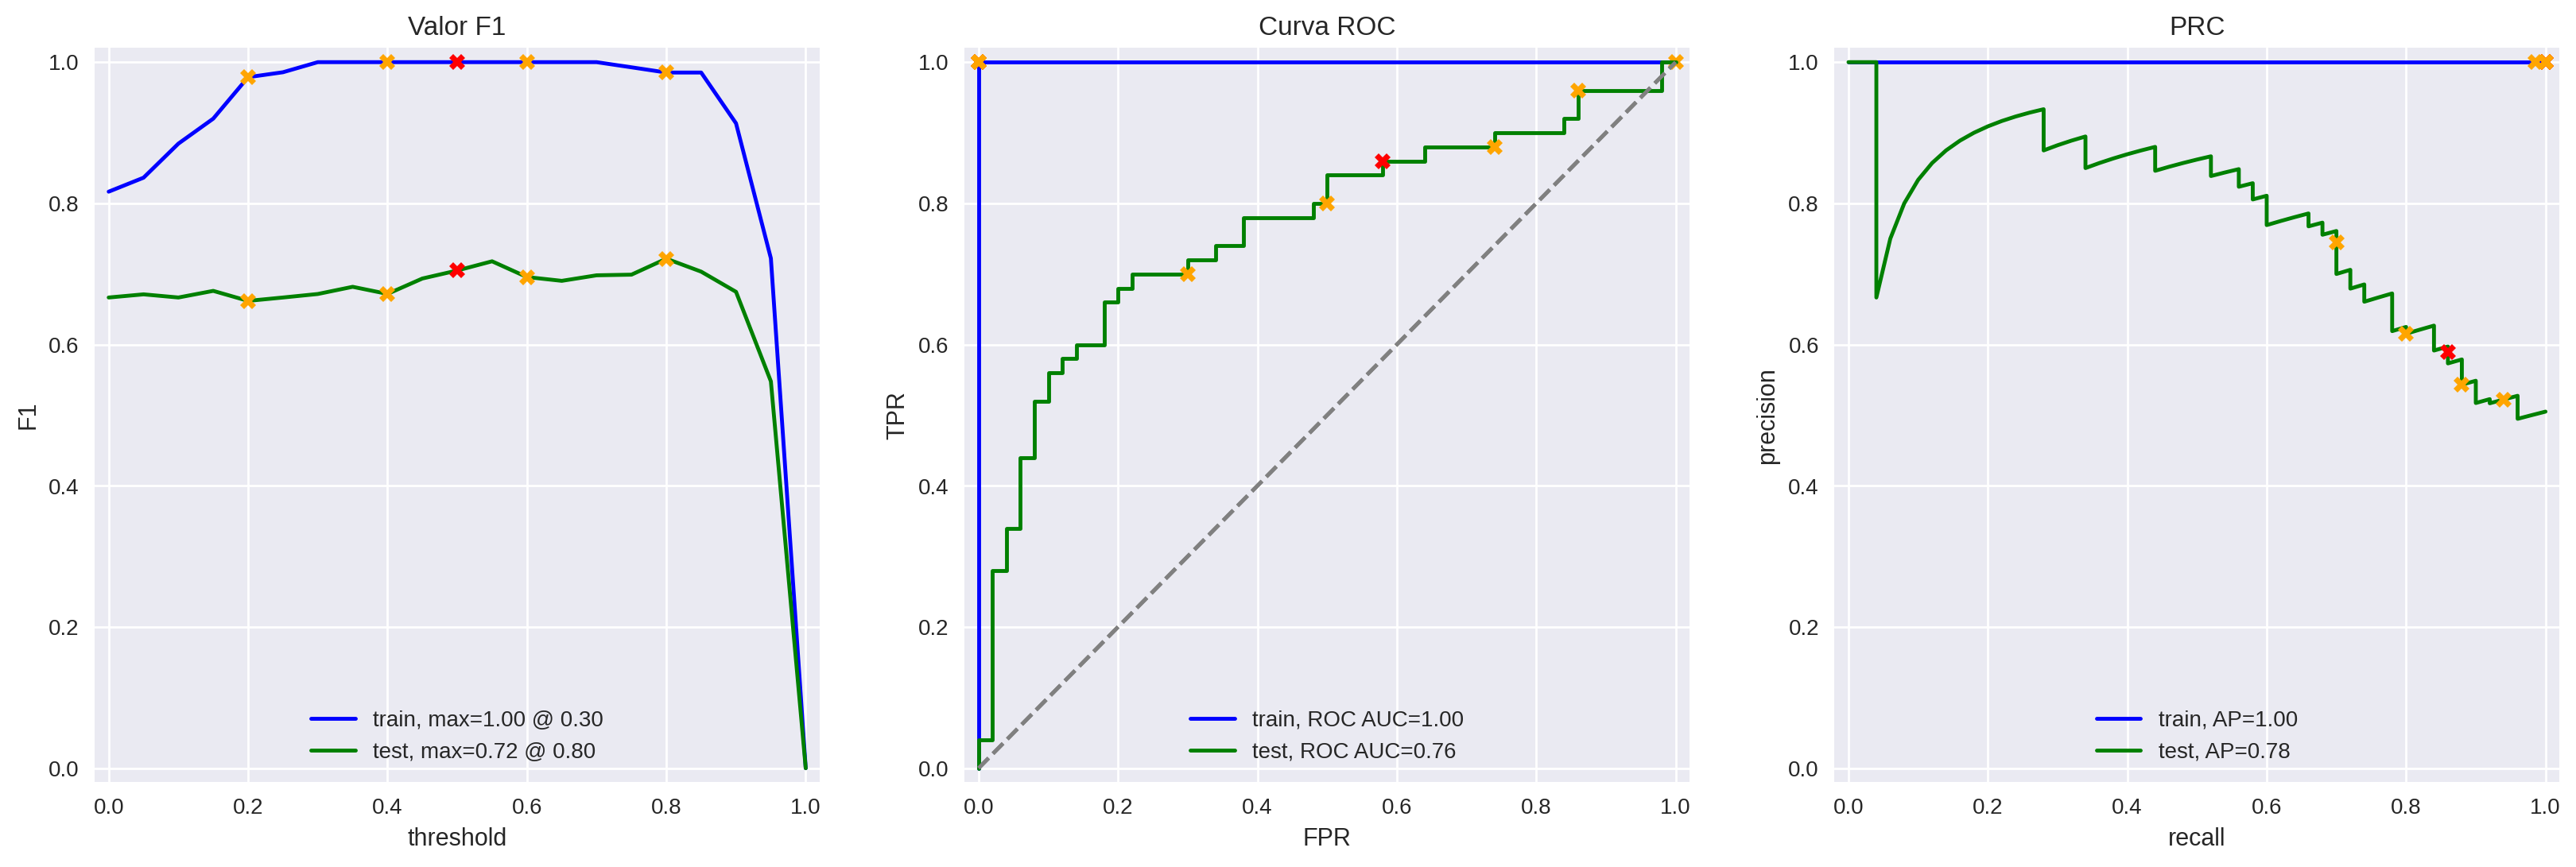

In [19]:
evaluate_model(model_4, train_features_4, train_target.iloc[:100], test_features_4, test_target.iloc[:100])

Este modelo presentó un sobreajuste significativo. Aunque su rendimiento en entrenamiento fue perfecto, no generalizó bien a los datos de prueba. Esto se debe a que solo se usaron 100 entradas para el entrenamiento y otras cien para las pruebas, ademas de las restricciones creadas por la computacion disponible.

### Cargar los embeddings

In [14]:
with np.load('features_4.npz') as data:
    train_features_4 = data['train_features_4']
    test_features_4 = data['test_features_4']

| Modelo     | Métrica     | Entrenamiento | Prueba  |
|------------|-------------|---------------|---------|
| Modelo 0   | F1          | 0.67          | 0.67    |
|            | ROC AUC     | 0.5           | 0.5     |
|            | APS         | 0.5           | 0.5     |
|            | Exactitud   | NaN           | NaN     |
| Modelo 1   | F1          | 0.94          | 0.88    |
|            | ROC AUC     | 0.98          | 0.95    |
|            | APS         | 0.98          | 0.95    |
|            | Exactitud   | NaN           | NaN     |
| Modelo 2   | F1          | 0.93          | 0.88    |
|            | ROC AUC     | 0.98          | 0.95    |
|            | APS         | 0.98          | 0.95    |
|            | Exactitud   | NaN           | NaN     |
| Modelo 3   | F1          | 0.91          | 0.86    |
|            | ROC AUC     | 0.97          | 0.94    |
|            | APS         | 0.97          | 0.93    |
|            | Exactitud   | NaN           | NaN     |
| Modelo 4   | F1          | 1.0           | 0.70    |
|            | ROC AUC     | 1.0           | 0.76    |
|            | APS         | 1.0           | 0.78    |
|            | Exactitud   | NaN           | NaN     |


## Mis reseñas

Probamos los modelos entrenados con algunas reseñas personales para ver cómo funcionan en casos no vistos.

In [16]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


### Modelo 1

In [20]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.18:  well i was bored and felt asleep in the middle of the movie
0.56:  i was really fascinated with the movie
0.12:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didnt expect the reboot to be so good writers really cared about the source material
0.48:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.05:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.84:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Modelo 2

In [26]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.12:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.10:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.27:  i didnt expect the reboot to be so good writers really cared about the source material
0.48:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Modelo 3

In [28]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.56:  i did not simply like it not my kind of movie
0.36:  well i was bored and felt asleep in the middle of the movie
0.60:  i was really fascinated with the movie
0.40:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.69:  i didnt expect the reboot to be so good writers really cared about the source material
0.68:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.27:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.78:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Modelo 4

In [21]:
texts = my_reviews['review_norm']

my_reviews_features_4 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_4.predict_proba(my_reviews_features_4)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  i did not simply like it not my kind of movie
0.23:  well i was bored and felt asleep in the middle of the movie
0.47:  i was really fascinated with the movie
0.03:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.57:  i didnt expect the reboot to be so good writers really cared about the source material
0.96:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.09:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.96:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


| Reseña                                                        | Modelo 1 | Modelo 2 | Modelo 3 | Modelo 4 |
|---------------------------------------------------------------|----------|----------|----------|----------|
| I did not simply like it, not my kind of movie.               | 0.16     | 0.20     | 0.56     | 0.21     |
| Well, I was bored and felt asleep in the middle of the movie. | 0.18     | 0.12     | 0.36     | 0.23     |
| I was really fascinated with the movie.                       | 0.56     | 0.49     | 0.60     | 0.47     |
| Even the actors looked really old and disinterested.          | 0.12     | 0.10     | 0.40     | 0.03     |
| I didn't expect the reboot to be so good!                     | 0.26     | 0.27     | 0.69     | 0.57     |
| The movie had its upsides and downsides, but I feel like...   | 0.48     | 0.48     | 0.68     | 0.96     |
| What a rotten attempt at a comedy.                            | 0.05     | 0.03     | 0.27     | 0.09     |
| Launching on Netflix was a brave move...                      | 0.84     | 0.92     | 0.78     | 0.96     |


## Conclusiones

En conclusión, los modelos basados en TF-IDF y regresión logística (Modelos 1 y 2) demostraron ser los más efectivos, superando consistentemente el umbral de F1 de 0.85 y ofreciendo un equilibrio adecuado entre precisión y complejidad del modelo. El uso de técnicas de lematización con spaCy (Modelo 2) no ofreció mejoras significativas en comparación con la simple remoción de stopwords (Modelo 1).

El modelo basado en LightGBM (Modelo 3) también mostró un rendimiento competente, mientras que el modelo BERT (Modelo 4) evidenció problemas de sobreajuste y requeriría ajustes adicionales para mejorar su generalización. Sin duda, con mayor poder computacional podria generar los mejores resultados.

Estos resultados sugieren que para la tarea de clasificación de reseñas de películas, las técnicas de procesamiento de lenguaje natural básicas combinadas con modelos de clasificación lineales son suficientemente robustas y eficaces. Para futuros trabajos, se podría explorar una mayor optimización de los hiperparámetros y la inclusión de más datos para mejorar la robustez y precisión del modelo.
